In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 1000
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\AI-lab\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\AI-lab\github_repo\neural-network\python\ga.py:203: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8641975308641975, Loss: 0.4430714006777163
Checkpoint 200, Accuracy: 0.8703703703703703, Loss: 0.4162890116373698
Checkpoint 300, Accuracy: 0.8827160493827161, Loss: 0.3907268665455006
Checkpoint 400, Accuracy: 0.8950617283950617, Loss: 0.3650264386777525
Checkpoint 500, Accuracy: 0.9074074074074074, Loss: 0.3429859655874747
Checkpoint 600, Accuracy: 0.9320987654320988, Loss: 0.3242714493362992
Checkpoint 700, Accuracy: 0.9197530864197531, Loss: 0.30719587537977433
Checkpoint 800, Accuracy: 0.9444444444444444, Loss: 0.285903877682156
Checkpoint 900, Accuracy: 0.9506172839506173, Loss: 0.27594195471869576
Checkpoint 1000, Accuracy: 0.9506172839506173, Loss: 0.2612241992244014


In [10]:
train_acc = [ h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [11]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [0.40223473 0.00075021 0.5970151 ]
[1. 0. 0.] <-> [0.9436723  0.00183883 0.05448882]
[0. 1. 0.] <-> [0.43412668 0.56206614 0.00380719]
[1. 0. 0.] <-> [0.6208846  0.00512932 0.37398604]
[1. 0. 0.] <-> [0.9575487  0.01421824 0.02823308]
[1. 0. 0.] <-> [0.97130144 0.01379904 0.01489955]
[0. 0. 1.] <-> [0.8822633  0.00739423 0.1103424 ]
[0. 1. 0.] <-> [0.7401474  0.2512458  0.00860683]
[1. 0. 0.] <-> [0.98005325 0.00785555 0.01209128]
[1. 0. 0.] <-> [0.8307785  0.14117263 0.02804888]
[1. 0. 0.] <-> [0.5896837  0.01378226 0.396534  ]
[1. 0. 0.] <-> [0.89811724 0.0896451  0.01223776]
[1. 0. 0.] <-> [0.95249873 0.00444072 0.04306049]
[1. 0. 0.] <-> [0.8806435  0.00445958 0.11489694]
[1. 0. 0.] <-> [0.90105087 0.00188304 0.09706608]
[1. 0. 0.] <-> [0.9526477  0.02491795 0.02243437]
[0. 0. 1.] <-> [0.36897838 0.00101036 0.6300113 ]
[0. 0. 1.] <-> [0.20005961 0.00455517 0.7953852 ]
[1. 0. 0.] <-> [0.74579704 0.00233208 0.2518709 ]
[1. 0. 0.] <-> [0.9747284  0.00304503 0.02222652]


In [13]:
# Testing Performance

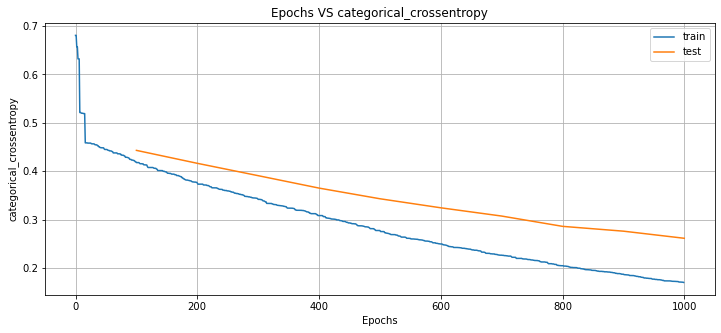

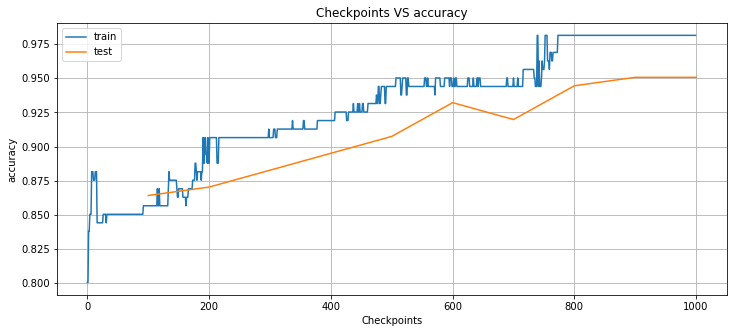

In [14]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [15]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8641975308641975, 'mean_square_error': 0.24252426726138832, 'categorical_crossentropy': 0.4430714006777163, 'precision': 0.7962962962962963, 'recall': 0.7962962962962963, 'f1': 0.7962962962962963, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 21, 'tn_hit': 11, 'fn_hit': 1}, 1: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 90, 'fn_hit': 9}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 12}}, 'checkpoint': 100} 


{'accuracy': 0.8703703703703703, 'mean_square_error': 0.22887596753622363, 'categorical_crossentropy': 0.4162890116373698, 'precision': 0.8055555555555556, 'recall': 0.8055555555555556, 'f1': 0.8055555555555556, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 20, 'tn_hit': 12, 'fn_hit': 1}, 1: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 90, 'fn_hit': 9}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8827160493827161, 'mean_square_error': 0.2138310854983533, 'categorical_crossentropy': 0.3907268665455006, 'precision

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.7094629  -2.9865406   0.39272383  0.9629256   2.227575  ]
 bias: 2.4453139305114746

Neuron 1: weights:
[ 1.5250745   0.75899345 -2.9850214   2.120421   -2.5666914 ]
 bias: 1.094472885131836

Neuron 2: weights:
[ 1.3517963   2.6179042   0.91879004 -0.3347608   2.4824643 ]
 bias: 0.9954215288162231

Neuron 3: weights:
[-1.7003088   1.1043129   2.7062075  -1.669869    0.11640003]
 bias: 2.4663634300231934

$
Layer 2
Neuron 0: weights:
[1.8973944  1.2095273  0.08693725 3.        ]
 bias: -2.4984519481658936

Neuron 1: weights:
[-2.892412  -1.1956135  2.8878295  2.4758196]
 bias: -1.6827129125595093

Neuron 2: weights:
[ 2.5860236 -1.7526354  1.1535038 -2.5820458]
 bias: 0.13781465590000153

$

